In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Literal
from pydantic import BaseModel, Field

from dotenv import load_dotenv

load_dotenv()

True

In [2]:
model = ChatGoogleGenerativeAI(model='gemini-2.0-flash')

In [3]:
model.invoke("wbo?")

AIMessage(content='"WBO" most commonly refers to the **World Boxing Organization**. It\'s one of the major organizations that sanction professional boxing bouts worldwide, alongside the WBC, IBF, and WBA. They establish rules, rate boxers, and award championship titles.\n\nHowever, without further context, it could potentially refer to something else. To provide a more accurate answer, could you please provide more context? For example:\n\n*   Where did you see/hear "WBO"?\n*   What was the topic of conversation?\n\nWith more information, I can give you a more precise answer.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--8154a697-5708-4453-aa48-85d4c3358a09-0', usage_metadata={'input_tokens': 3, 'output_tokens': 122, 'total_tokens': 125, 'input_token_details': {'cache_read': 0}})

##### Schema 1: Postive/Negative
- for structured model 1 

In [18]:
# For structure output -> use Schema
class SentimentSchema(BaseModel):
    sentiment: Literal["positive","negative"] = Field(description="Sentiment of review")

##### Schema 2: Run diagnosis
- for structured model 2

In [19]:
class DiagnosisSchema(BaseModel): 
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')    

In [20]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

- test 

In [21]:
prompt = "What is the sentiment of the following review - The software is very bad"
structured_model.invoke(prompt).sentiment

'negative'

##### Schema 3: Review state (overall)


In [22]:
class ReviewState(TypedDict):
    
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis:  dict
    response: str

In [23]:
def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal['positive_response', 'run_diagnosis']: 

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
# Positive Response
def positive_response(state: ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review: \n\n "{state['review']} \n also, Kindly ask the user to leave feedback on our website. """  

    response = model.invoke(prompt).content  
    return {'response': response}

# Run diagonsis for negative response
def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency."""

    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}
    # response is -> pydantic object 
    # response -> json / pydantic object will convert into dict

# Negative Response
def negative_response(state: ReviewState):

    diagnosis = state['diagnosis'] # dict
#  below we are extracting keys of diagnosis dictionary

    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message.
    """ 
    response = model.invoke(prompt).content
    return {'response':response}

In [24]:
# Creating a graph

graph = StateGraph(ReviewState)

# nodes
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)
# graph.add_node('check_sentiment', check_sentiment)

# edges
graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)

graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()



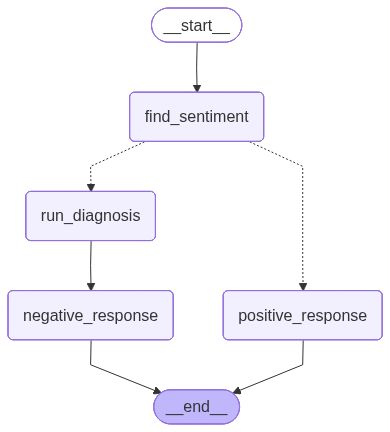

In [25]:
workflow

In [28]:
initial_state = {
    'review': "Ive been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(initial_state)

{'review': 'Ive been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'angry', 'urgency': 'high'},
 'response': "Okay, I understand you're experiencing a bug, you're understandably frustrated, and you need this resolved quickly. I want to assure you that I'm here to help and I'll do everything I can to get this sorted out for you.\n\nFirst, I want to sincerely apologize for the inconvenience this bug is causing. I know how disruptive these issues can be, especially when you have important tasks to complete.\n\nTo help me understand the situation and find the fastest solution, could you please provide a little more detail about:\n\n*   **What exactly is happening?** (Be as specific as possible, including error messages, steps to reproduce the issu